In [107]:
import sys
from pathlib import Path

import matplotlib.pyplot as plt
import nibabel as nib
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn.functional as F

sns.set_theme(
    context="notebook",
    style="whitegrid",
    palette="deep",
    font="sans-serif",
    font_scale=2,
    color_codes=True,
    rc=None,
)

curdir = Path.cwd()
sys.path.append(curdir.parent)
from utils.metrics import dice_batch

results_path = curdir.parent / "results"
data_path = curdir.parent / "data"

dataset = "segthor_train"  # 3D

categories = ["Background", "Esophagus", "Heart", "Trachea", "Aorta"]
K = len(categories)

experiments_path = results_path / dataset
experiments = list(experiments_path.iterdir())
print("Found experiments:")
for i, exp in enumerate(experiments):
    print(f"{i}: {exp.stem}")
    
experiment = experiments[1]

Found experiments:
0: segvol
1: segvol_dicefocal_lr0
2: segvol_dicece_lr0
3: segvol_zeroshot


In [108]:
# # Manually select and save experiment since this hasn't been done for some cases

# patients = list(filter(lambda x: "pred.nii.gz" in x.name, experiment.iterdir()))

# store = np.zeros((len(patients), K))
# gt_path = data_path / dataset / "train"
# for i, patient in enumerate(patients):
#     patient_id = patient.stem.split("_pred")[0]
#     pred = np.asarray(nib.load(patient).dataobj)
#     gt = np.asarray(nib.load(gt_path / patient_id / "GT.nii.gz").dataobj)
#     pred, gt = torch.from_numpy(pred), torch.from_numpy(gt)
#     pred, gt = (
#         F.one_hot(pred.long(), K).permute(3, 0, 1, 2),
#         F.one_hot(gt.long(), K).permute(3, 0, 1, 2),
#     )
#     dice = dice_batch(gt.unsqueeze(0), pred.unsqueeze(0))
#     store[i] = dice.cpu().numpy()
#     del pred, gt
#     print(dice)

# np.save(experiment / "dice_pred.npy", store)

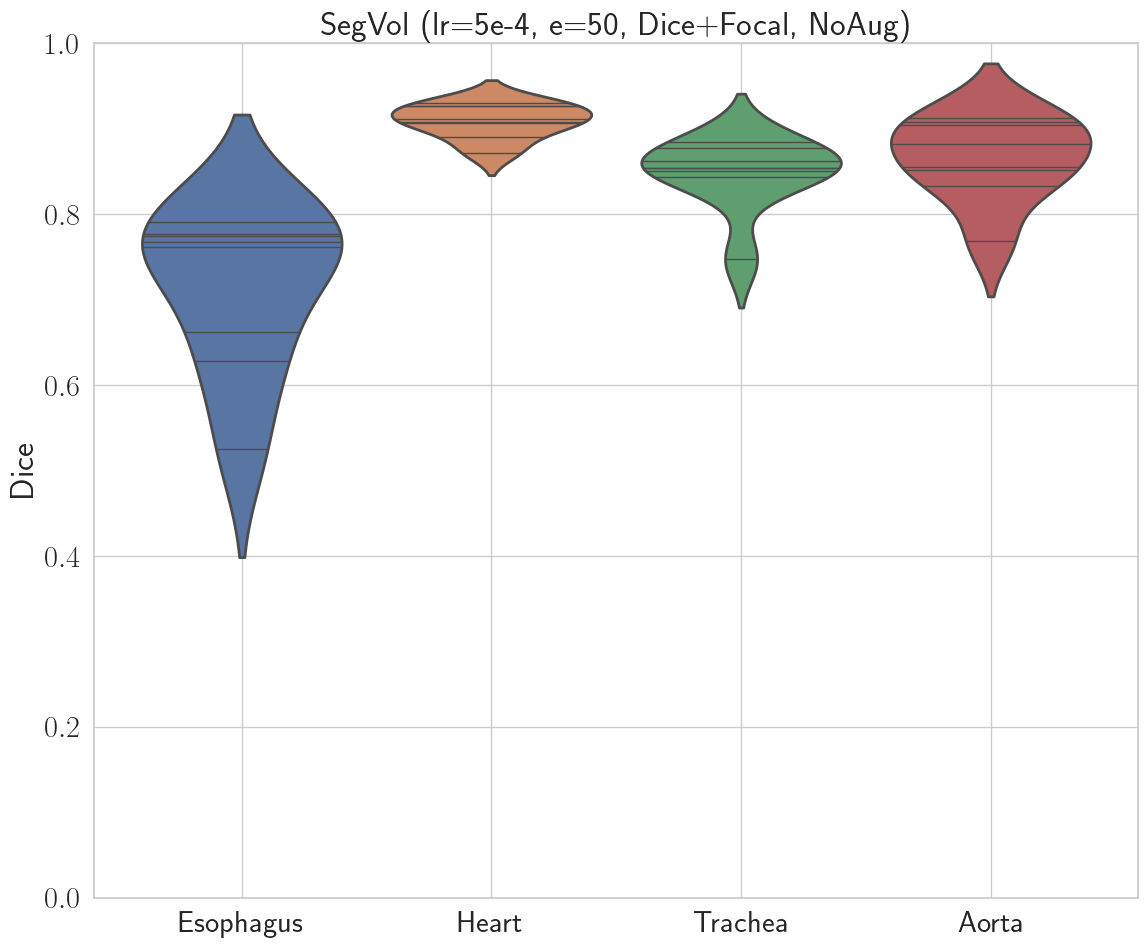

In [120]:
experiment = experiments[0]
store = np.load(experiment / "dice_pred.npy")
store = store[:, 1:] # Exclude background
sns.violinplot(
    data=store,
    density_norm="width",
    native_scale=True,
    linewidth=2,
    common_norm=False,
    inner="stick",
)
plt.ylim(0, 1)
plt.xticks(ticks=np.arange(K - 1), labels=categories[1:])
plt.ylabel("Dice")
plt.title(f"SegVol (lr=5e-4, e=50, Dice+Focal, NoAug)")
plt.tight_layout()
save_dir = curdir / experiment.stem / "dice_pred.png"
save_dir.parent.mkdir(parents=True, exist_ok=True)
plt.savefig(save_dir, bbox_inches="tight")

## Display Violin plots side by side.

,Experiment,Category,Dice
0,Aug,Esophagus,0.773900
1,Aug,Esophagus,0.628600
2,Aug,Esophagus,0.790200
3,Aug,Esophagus,0.767100
4,Aug,Esophagus,0.661500
...,...,...,...
59,NoAug,Aorta,0.781423
60,NoAug,Aorta,0.824589
61,NoAug,Aorta,0.781207
62,NoAug,Aorta,0.847573


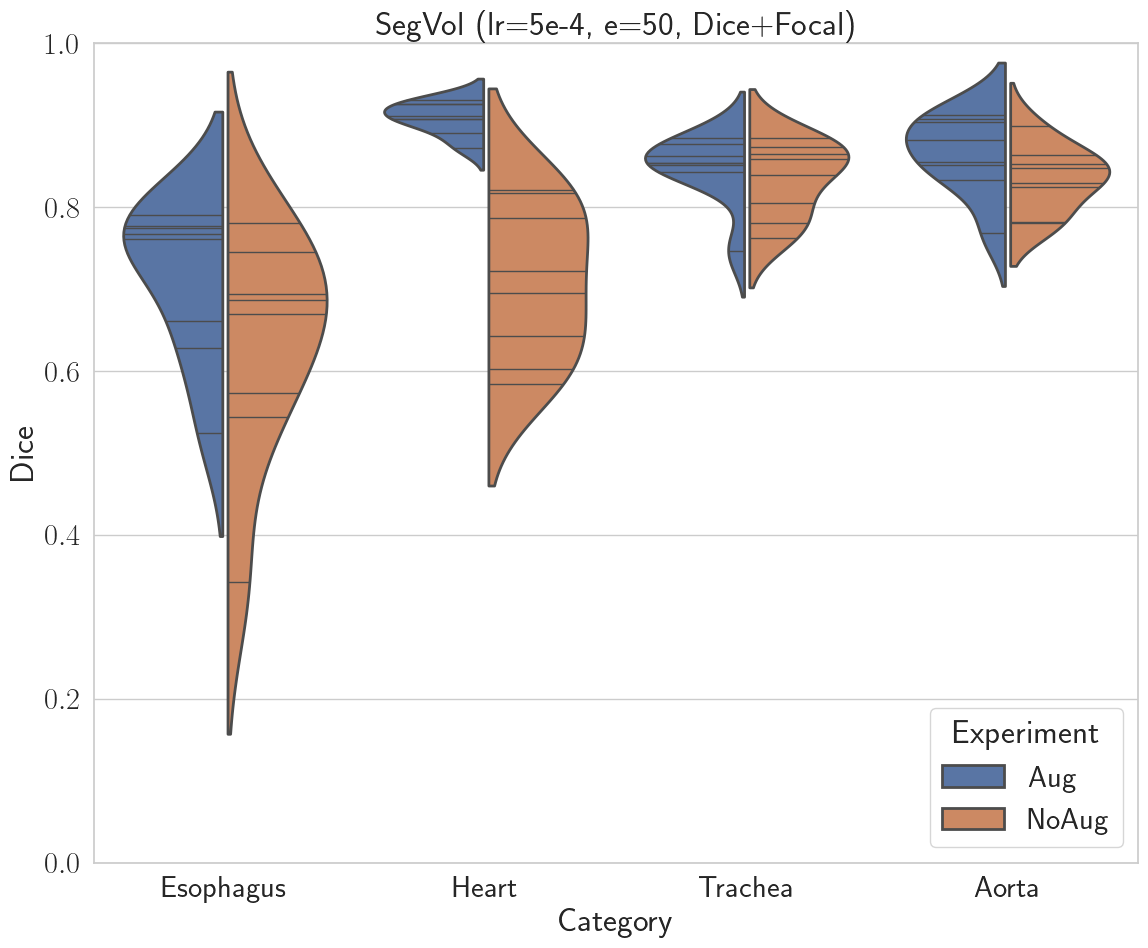

<Figure size 1200x1000 with 0 Axes>

In [121]:
store_1 = np.load(experiments[0] / "dice_pred.npy")
store_1 = store_1[:, 1:]  # Exclude background

store_2 = np.load(experiments[1] / "dice_pred.npy")
store_2 = store_2[:, 1:]  # Exclude background

df = pd.concat(
    [
        pd.DataFrame(store_1, columns=categories[1:]).assign(Experiment="Aug"),
        pd.DataFrame(store_2, columns=categories[1:]).assign(Experiment="NoAug"),
    ]
)

# Convert dataframe from wide-form to long-form
df_long = pd.melt(df, id_vars=["Experiment"], var_name="Category", value_name="Dice")
display(df_long)
# Create a violin plot
sns.violinplot(
    data=df_long,
    x="Category",
    y="Dice",
    hue="Experiment",
    density_norm="count",
    native_scale=True,
    linewidth=2,
    gap=0.05,
    common_norm=False,
    split=True,
    inner="stick",
)
plt.ylim(0, 1)
plt.ylabel("Dice")
plt.title(f"SegVol (lr=5e-4, e=50, Dice+Focal)")
plt.tight_layout()
plt.show()
save_dir = curdir / "dice_pred_aug_vs_noaug.png"
plt.savefig(save_dir, bbox_inches="tight")